In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Bibliotecas

In [2]:
pip install CatBoost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 137 kB/s 


In [35]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
import catboost as cb

 
import warnings; warnings.simplefilter('ignore')

# DataFrame Prepared

### Importando Dataframe e separando em train / predict

In [4]:
%%time
df_uni =pd.read_csv('/content/drive/MyDrive/TCC/df_final.csv')

CPU times: user 20.8 s, sys: 8.64 s, total: 29.4 s
Wall time: 38.7 s


In [ ]:
df_uni.head()

,Unnamed: 0,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,id,test,mediaClientProd,quantClientProd,mediaProd,quantProd,mediaClient,quantClient
0,0,9,2655,2,4189,26,30235,4.574711,0,0,0.0,0.0,32.435081,1602.0,27.091603,131.0
1,1,9,2061,2,7212,26,31393,2.639057,0,0,17.5,4.0,11.782707,13300.0,27.091603,131.0
2,2,10,2655,2,4189,26,31518,0.000000,1569352,1,0.0,0.0,13.333333,129.0,27.091603,131.0
3,3,11,2655,2,4189,26,31520,0.000000,4728674,1,0.0,0.0,27.497359,1136.0,27.091603,131.0
4,4,9,2061,2,7212,26,32962,2.397895,0,0,0.0,0.0,20.038141,5873.0,27.091603,131.0


In [5]:
train = df_uni[df_uni['test']==0]
predict = df_uni[df_uni['test']==1]

### Train test split

In [6]:
y = train['Demanda_uni_equil']
X = train[[ 'Agencia_ID','Canal_ID','Cliente_ID','Producto_ID','Ruta_SAK','mediaClientProd','quantClientProd', 'mediaProd', 'quantProd', 'mediaClient','quantClient']]

In [ ]:
print(X.shape, y.shape)

(10408713, 11) (10408713,)


In [7]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape , y_test.shape)

(6245227, 11) (4163486, 11) (6245227,) (4163486,)


In [8]:
df_train_split = X_train.sample(frac=0.1, random_state=200)
print(df_train_split.shape)

df_train_y_split = y_train.sample(frac=0.1, random_state=200)
print(df_train_y_split.shape)

(624523, 11)
(624523,)


In [9]:

# Create the parameter grid based on the results of random search 
param_grid = {
    
    'max_depth': [2, 6, 12],
    'n_estimators': [200, 300, 500, 800, 1200]
}
# Create a based model
rf = cb.CatBoostRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(df_train_split, df_train_y_split)

print(grid_search.best_params_)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Learning rate set to 0.097612
0:	learn: 0.7920471	total: 133ms	remaining: 2m 39s
1:	learn: 0.7516755	total: 210ms	remaining: 2m 6s
2:	learn: 0.7164432	total: 280ms	remaining: 1m 51s
3:	learn: 0.6854507	total: 356ms	remaining: 1m 46s
4:	learn: 0.6588239	total: 435ms	remaining: 1m 43s
5:	learn: 0.6351186	total: 508ms	remaining: 1m 41s
6:	learn: 0.6152255	total: 591ms	remaining: 1m 40s
7:	learn: 0.5976366	total: 664ms	remaining: 1m 38s
8:	learn: 0.5831496	total: 735ms	remaining: 1m 37s
9:	learn: 0.5702786	total: 807ms	remaining: 1m 35s
10:	learn: 0.5588351	total: 881ms	remaining: 1m 35s
11:	learn: 0.5495472	total: 954ms	remaining: 1m 34s
12:	learn: 0.5414012	total: 1.02s	remaining: 1m 33s
13:	learn: 0.5345570	total: 1.1s	remaining: 1m 33s
14:	learn: 0.5282682	total: 1.18s	remaining: 1m 33s
15:	learn: 0.5228468	total: 1.25s	remaining: 1m 32s
16:	learn: 0.5185098	total: 1.33s	remaining: 1m 32s
17:	learn: 0.5142298	total: 1.4s	rema

In [10]:

print(grid_search.best_params_)


{'max_depth': 6, 'n_estimators': 1200}


# XGboost

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear',max_depth = 12, alpha = 10, n_estimators = 2 , subsample=0.85 ,verbose=True)

In [ ]:
xg_reg.fit(X_train,y_train)

In [ ]:
y_pred_xgb = xg_reg.predict(X_test)

In [ ]:
y_pred_xgb

##  Root Mean Squared Logaritmic Error (RMSLE) XGboost

In [ ]:
rmsle_xgb = np.sqrt(mean_squared_log_error(y_test, y_pred_xgb))

In [ ]:
rmsle_xgb

# CatBoost Regressor

In [24]:
CB_reg = cb.CatBoostRegressor(max_depth= 6, iterations = 50, objective='MAE' ,random_seed=42, verbose=True)

In [25]:
CB_reg.fit(X_train,y_train)

0:	learn: 0.6257508	total: 1.31s	remaining: 1m 4s
1:	learn: 0.6161207	total: 2.49s	remaining: 59.9s
2:	learn: 0.6069351	total: 3.59s	remaining: 56.3s
3:	learn: 0.5979463	total: 4.66s	remaining: 53.6s
4:	learn: 0.5890623	total: 5.7s	remaining: 51.3s
5:	learn: 0.5803477	total: 6.71s	remaining: 49.2s
6:	learn: 0.5721598	total: 7.74s	remaining: 47.5s
7:	learn: 0.5641987	total: 8.8s	remaining: 46.2s
8:	learn: 0.5565277	total: 9.82s	remaining: 44.8s
9:	learn: 0.5491451	total: 10.9s	remaining: 43.5s
10:	learn: 0.5419601	total: 11.9s	remaining: 42.3s
11:	learn: 0.5349574	total: 13s	remaining: 41s
12:	learn: 0.5285120	total: 14s	remaining: 39.9s
13:	learn: 0.5221802	total: 15s	remaining: 38.7s
14:	learn: 0.5159339	total: 16s	remaining: 37.4s
15:	learn: 0.5099980	total: 17.1s	remaining: 36.3s
16:	learn: 0.5042222	total: 18.1s	remaining: 35s
17:	learn: 0.4982942	total: 19s	remaining: 33.9s
18:	learn: 0.4928230	total: 20.1s	remaining: 32.7s
19:	learn: 0.4878040	total: 21s	remaining: 31.6s
20:	lear

In [30]:
CB_reg.feature_importances_

array([ 0.        ,  0.        ,  0.        ,  0.36951727,  1.798844  ,
       65.64253961,  6.02736973, 18.99525613,  0.19585928,  4.83920886,
        2.13140512])

Text(0.5, 1.0, 'Importância de cada feature')

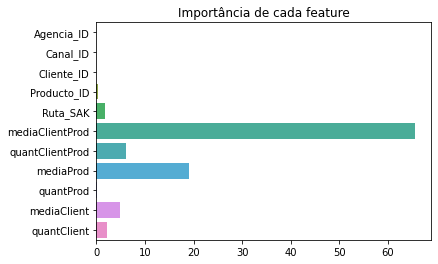

In [32]:
import seaborn as sns
importances = pd.Series(data=CB_reg.feature_importances_, index=CB_reg.feature_names_)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

In [26]:
y_pred_CB = CB_reg.predict(X_test)

In [27]:
y_pred_CB

array([1.63943058, 1.11281814, 2.17877205, ..., 1.19574878, 0.97179065,
       1.09347775])

## Root Mean Squared Logaritmic Error (RMSLE) CatBoost

In [28]:
rmsle_CB = np.sqrt(mean_squared_log_error(y_test, y_pred_CB))

In [29]:
rmsle_CB

0.21560479175638828

## Root Mean Squared  Error (RMSE) CatBoost

In [36]:
rmse_Cb  = np.sqrt(mean_squared_error(y_test, y_pred_CB))

In [37]:
rmse_Cb

0.5459101828236594

## Mean Absolute Error (MAE) Catboost

In [38]:
mae_Cb  = np.sqrt(mean_absolute_error(y_test, y_pred_CB))

In [39]:
mae_Cb

0.6355041516260332

In [ ]:
#CB_reg.plot_tree(tree_idx=0)

# Submission

In [ ]:
predict.drop('Unnamed: 0', axis=1 ,inplace=True)

In [ ]:
predict.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,id,test,mediaClientProd,quantClientProd,mediaProd,quantProd,mediaClient,quantClient
2,10,2655,2,4189,26,31518,0.0,1569352,1,0.000000,0.0,13.333333,129.0,27.091603,131.0
3,11,2655,2,4189,26,31520,0.0,4728674,1,0.000000,0.0,27.497359,1136.0,27.091603,131.0
7,11,2061,2,7212,26,34206,0.0,1547831,1,74.000000,4.0,25.740823,64261.0,27.091603,131.0
9,10,2061,2,7212,26,34210,0.0,6667200,1,36.000000,4.0,119.835431,8659.0,27.091603,131.0
14,10,2061,2,7212,26,34785,0.0,1592616,1,18.333333,3.0,85.906958,8609.0,27.091603,131.0


In [ ]:
predict[predict['Semana']==10]

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,id,test,mediaClientProd,quantClientProd,mediaProd,quantProd,mediaClient,quantClient
2,10,2655,2,4189,26,31518,0.0,1569352,1,0.000000,0.0,13.333333,129.0,27.091603,131.0
9,10,2061,2,7212,26,34210,0.0,6667200,1,36.000000,4.0,119.835431,8659.0,27.091603,131.0
14,10,2061,2,7212,26,34785,0.0,1592616,1,18.333333,3.0,85.906958,8609.0,27.091603,131.0
17,10,2061,2,7212,26,34786,0.0,3909690,1,64.000000,4.0,159.838933,10567.0,27.091603,131.0
22,10,2061,2,7212,26,35142,0.0,3659672,1,38.250000,4.0,50.066907,8594.0,27.091603,131.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17407949,10,22362,1,900,2015152015,1230,0.0,608029,1,0.000000,0.0,2.079283,371654.0,39.789474,19.0
17407951,10,22362,1,900,2015152015,1232,0.0,5838266,1,0.000000,0.0,2.873842,814164.0,39.789474,19.0
17407954,10,22362,1,900,2015152015,1238,0.0,2542921,1,0.000000,0.0,3.107030,660831.0,39.789474,19.0
17407956,10,22362,1,900,2015152015,1250,0.0,3223836,1,16.000000,1.0,6.464144,1062639.0,39.789474,19.0


In [ ]:
X_semana_10 =  predict[predict['Semana']==10][['Agencia_ID','Canal_ID','Cliente_ID','Producto_ID','Ruta_SAK','mediaClientProd','quantClientProd', 'mediaProd', 'quantProd', 'mediaClient','quantClient']]
X_semana_11 =  predict[predict['Semana']==11][['Agencia_ID','Canal_ID','Cliente_ID','Producto_ID','Ruta_SAK','mediaClientProd','quantClientProd', 'mediaProd', 'quantProd', 'mediaClient','quantClient']]

In [ ]:
X_semana_10.head()

,Agencia_ID,Canal_ID,Cliente_ID,Producto_ID,Ruta_SAK,mediaClientProd,quantClientProd,mediaProd,quantProd,mediaClient,quantClient
2,2655,2,26,31518,4189,0.000000,0.0,13.333333,129.0,27.091603,131.0
9,2061,2,26,34210,7212,36.000000,4.0,119.835431,8659.0,27.091603,131.0
14,2061,2,26,34785,7212,18.333333,3.0,85.906958,8609.0,27.091603,131.0
17,2061,2,26,34786,7212,64.000000,4.0,159.838933,10567.0,27.091603,131.0
22,2061,2,26,35142,7212,38.250000,4.0,50.066907,8594.0,27.091603,131.0


## XGboost Regressor

In [ ]:
y_semana_10_xgb = xg_reg.predict(X_semana_10)
y_semana_11_xgb = xg_reg.predict(X_semana_11)

In [ ]:
# Inverse np.log1p
submission_10_xgb = pd.DataFrame({'id':predict[predict['Semana']==10]['id'], 'Demanda_uni_equil': np.expm1(y_semana_10_xgb)})
submission_11_xgb = pd.DataFrame({'id':predict[predict['Semana']==11]['id'], 'Demanda_uni_equil':np.expm1(y_semana_11_xgb)}) 

In [ ]:
submit_xgb = pd.concat([submission_10_xgb[['id','Demanda_uni_equil']],submission_11_xgb[['id','Demanda_uni_equil']]], axis=0, copy=True)

In [ ]:
submit_xgb

,id,Demanda_uni_equil
2,1569352,1.644082
9,6667200,1.973643
14,1592616,1.566669
17,3909690,2.359953
22,3659672,1.973643
...,...,...
17407943,2306934,0.866875
17407944,4894078,0.866875
17407945,3413579,1.410419
17407952,6093628,0.753181


In [ ]:
submit_xgb.to_csv('/content/drive/MyDrive/TCC/prediction_xgb1.csv', index=False)

## CatBoost Regressor

In [ ]:
y_semana_10_CB = CB_reg.predict(X_semana_10)
y_semana_11_CB = CB_reg.predict(X_semana_11)

In [ ]:
# Inverse np.log1p
submission_10_CB = pd.DataFrame({'id':predict[predict['Semana']==10]['id'], 'Demanda_uni_equil': np.expm1(y_semana_10_CB)})
submission_11_CB = pd.DataFrame({'id':predict[predict['Semana']==11]['id'], 'Demanda_uni_equil':np.expm1(y_semana_11_CB)}) 

In [ ]:
submit_CB = pd.concat([submission_10_CB[['id','Demanda_uni_equil']],submission_11_CB[['id','Demanda_uni_equil']]], axis=0, copy=True)

In [ ]:
submit_CB

,id,Demanda_uni_equil
2,1569352,4.809548
9,6667200,19.024844
14,1592616,13.164300
17,3909690,19.024844
22,3659672,19.024844
...,...,...
17407943,2306934,2.341711
17407944,4894078,2.341711
17407945,3413579,3.741211
17407952,6093628,1.851421


In [ ]:
submit_CB.to_csv('/content/drive/MyDrive/TCC/prediction_CB.csv', index=False)